## Exercise 1

Example solution provided by Tania Kozynets (AMAS-2021 TA), Feb. 15, 2021; see alternative solutions by [Niccolo](https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/Exercises/Lecture3_likelihood_niccolo.py) (AMAS-2017 TA) and [Jean-Loup](https://www.nbi.dk/~koskinen/Teaching/AdvancedMethodsInAppliedStatistics2021/Exercises/Lecture3_Exercise1.ipynb) (AMAS-2019 TA).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import itertools
#from tqdm import tqdm

### My pretty plotting routines

In [ ]:
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)


### Defining the likelihood functions


In [ ]:
def likelihood(x,mu,sigma):
    #The likelihood to get the x-points (individually) given a gaussian PDF with parameters mean=mu, std=sigma.
    return (1/np.sqrt(2*np.pi*sigma**2))*np.exp(-(x-mu)**2/(2*sigma**2))

def log_likelihood(x,mu,sigma):
    #The log-likelihood to get all of the x-points (together) given a gaussian PDF with parameters mean=mu,std=sigma.
    return np.sum(np.log(likelihood(x,mu,sigma)),axis=1)

### Defining and sampling the gaussian PDF 

In [ ]:
#Default number of "throws" (draws from the gaussian)
num_samples = 50

#True standard deviation and mean
true_gauss_sigma = 0.1
true_gauss_mu = 0.2

#Points sampled from the defined gaussian distribution
x_samples = np.random.normal(loc=true_gauss_mu,scale=true_gauss_sigma,size=num_samples)
#We will expand the first dimension of the x_samples array to enable execution of the log_likelihood function
#in the case when both x_samples and mu/sigma are arrays. All this does is that it changes the shape of x_samples
#from (num_samples,) to (1,num_samples).
x_samples = np.expand_dims(x_samples,axis=0)

### Defining the grid for the raster scan

In [6]:
#We know what the true values are — therefore, we will scan the grid in their vicinity. 
#The grid will be linearly spaced for mu... (the true value is 0.2, so I go -0.4..+0.4 around that value)
mu_range = np.linspace(-0.2,0.6,100)
#and log-spaced for sigma (the true value is log10[0.1] = -1)
sigma_range = np.logspace(-1.5,0,100)

#Next, we create all possible combinations of mu-sigma pairs with itertools.product. This is equivalent
#to numpy.meshgrid and returns a 2D array with mu values in the first column and sigma values in the second one.
mu_sigma_pairs = np.array(list(itertools.product(mu_range,sigma_range)))

#Breaking down the mu-sigma values in the 2D grid into separate arrays and expanding their axes to enable
#arithmetic operations with x_samples.
mus_from_grid = np.expand_dims(mu_sigma_pairs[:,0],axis=1)
sigmas_from_grid = np.expand_dims(mu_sigma_pairs[:,1],axis=1)

### Performing the raster scan

Now, we will evaluate our log-likelihood (LLH) on the values of $\mu$ and $\sigma$ that belong to our grid. The likelihood will be evaluated given the observed samples (**x_samples**).

In [7]:
scanned_llh = log_likelihood(x_samples,mus_from_grid,sigmas_from_grid)

#after the scan, we find the index in the flat scanned_llh array that gives us the maximum likelihood
ind_max_llh = np.argmax(scanned_llh)

### Plotting the results of the raster scan

We will find that the ($\mu$,$\sigma$) coordinates of the true maximum LLH do not exactly match the ones that maximize the scanned likelihood. This is expected given a relatively small number of observations (50) and a finite resolution of the grid. 

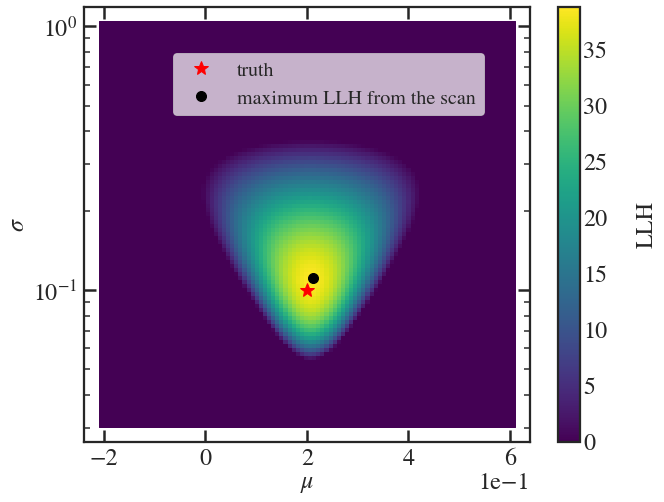

In [8]:
reset_plt(24,24)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)

#raster scan results
sc = ax.scatter(mus_from_grid,sigmas_from_grid,c=scanned_llh,
               marker = 's', s = 100, vmin = 0, cmap = 'viridis')

#the truth
ax.plot(true_gauss_mu,true_gauss_sigma,marker='*',color='red',markersize=15,ls='none', 
       label = 'truth')

#the maximum of the raster scan LLH
ax.plot(mus_from_grid[ind_max_llh],sigmas_from_grid[ind_max_llh], marker = 'o', ls='none',
        color = 'black',markersize = 10, label = 'maximum LLH from the scan')

ax.set_yscale('log')
ax.legend(loc = (0.2,0.75), fontsize = 20,framealpha=0.7,frameon=True)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

cb = fig.colorbar(sc,label='\nLLH')
put_ticks(fig,ax)


### Running multiple trials

Each trial = 50 different samples from the gaussian (same true mean & standard deviation). We will wrap the above calculation in a function to run 200 of these trials, storing the true maximum likelihood (MLE assuming the true parameters) and the one from the raster scan for each of them. 

In [9]:
def sample_and_scan(true_mu,true_sigma,num_trials):
    
    #the placeholders for the raster scan LLH and the LLH assuming the truth
    scan_max_llh = []
    true_max_llh = []
    
    #Looping through the trials
    for i in (range(num_trials)):
        
        #Drawing samples from the gaussian
        x_samples = np.random.normal(loc=true_gauss_mu,scale=true_gauss_sigma,size=num_samples)
        x_samples = np.expand_dims(x_samples,axis=0)
        
        #Performing the raster scan over the mu-sigma grid defined earlier
        scanned_llh = log_likelihood(x_samples,mus_from_grid,sigmas_from_grid)
        
        #Calculating the LLH assuming the truth
        this_true_llh = log_likelihood(x_samples,np.expand_dims([true_gauss_mu],axis=0),
                                  np.expand_dims([true_gauss_sigma],axis=0)).flatten()[0]
        
        #Storing the results
        scan_max_llh = np.append(scan_max_llh,np.max(scanned_llh))
        true_max_llh = np.append(true_max_llh,this_true_llh)
        
    return scan_max_llh,true_max_llh
         

In [10]:
num_trials = 100
raster_llh_res,true_llh_res = sample_and_scan(true_gauss_mu,true_gauss_sigma,num_trials)

### Comparing the LLH assuming the truth to the MLE from the raster scan

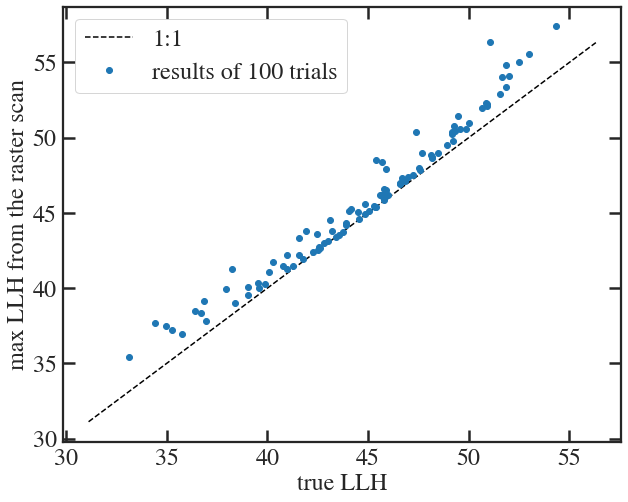

In [11]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

true_llh_arr = np.linspace(np.min(true_llh_res)-2,np.max(true_llh_res)+2,100)

ax.plot(true_llh_arr,true_llh_arr,ls='--',color='black',label = '1:1')
ax.plot(true_llh_res,raster_llh_res,ls='none',marker='o', label = 'results of %s trials'%num_trials)

put_ticks(fig,ax)
ax.set_xlabel('true LLH')
ax.set_ylabel('max LLH from the raster scan')

ax.legend(loc = 'upper left',frameon = True)
